In [2]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
from pathlib import Path

from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", 
              style="white")

from datasets import Dataset
import evaluate
from transformers import (BartTokenizer,
                          BartForConditionalGeneration,
                          DataCollatorForSeq2Seq,
                          EarlyStoppingCallback,
                          Seq2SeqTrainingArguments,
                          Seq2SeqTrainer, 
                          get_scheduler)
import torch
import bitsandbytes as bnb

c:\Users\Checkout\Documents\Fall 2023\uApply-Job-Recommendation-System\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


c:\Users\Checkout\Documents\Fall 2023\uApply-Job-Recommendation-System\myenv\Lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Import csv files dynamically
current_directory = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(current_directory, '..'))
job_posting = os.path.join(project_root, 'src', 'data', 'job_posting.csv')
job_posting = pd.read_csv(job_posting)

In [5]:
job_posting.shape

(33246, 34)

In [6]:
# NaNs count - Only on the columns we're interested in which are 'title' and 'description'
job_posting[["title", "description"]].isnull().sum()

title          0
description    1
dtype: int64

In [7]:
# Check where the NaNs are
nans_mask = (job_posting["title"].isnull()) | (job_posting["description"].isnull())
job_posting.loc[nans_mask]

,job_id,company_id,company_name,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,...,sponsored,work_type,currency,compensation_type,scraped,company_speciality,company_industry,company_description,linkedin_url,job_skills
26954,3694104501,157262,First Horizon Bank,Senior Universal Banker,NaN,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,NaN,Financial Services,When we opened our doors in 1864 on North Cour...,https://www.linkedin.com/company/first-horizon...,"Finance, Sales"


In [8]:
# Drop NaNs
print(f"Rows before: {job_posting.shape[0]}")
job_posting = job_posting[~nans_mask].reset_index(drop=True).copy(deep=True)
print(f"Rows after: {job_posting.shape[0]}")

Rows before: 33246
Rows after: 33245


In [9]:
# Text preprocessing
# Title with special characters

def has_special_char(text: str) -> bool:
    return any(c for c in text if not c.isalnum() and not c.isspace())

job_posting.loc[job_posting["title"].apply(lambda x: has_special_char(x))]

,job_id,company_id,company_name,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,...,sponsored,work_type,currency,compensation_type,scraped,company_speciality,company_industry,company_description,linkedin_url,job_skills
1,3757940025,2192142,"Metalcraft of Mayville, Inc.",Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699085420,"Metal Fabrication, Machining, Robotic Welding,...",Industrial Machinery Manufacturing,"Headquartered in Mayville, Wisconsin, Metalcra...",https://www.linkedin.com/company/metalcraft-of...,"Management, Manufacturing"
2,3757938019,474443,"U.S. Tsubaki Power Transmission, LLC","Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699085644,"Roller Chain, Engineering Class Chain, Sprocke...",Automation Machinery Manufacturing,"U.S. Tsubaki Power Transmission, LLC is a subs...",https://www.linkedin.com/company/u.s.-tsubaki-...,Engineering
4,3757937095,437225,"iHerb, LLC",Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,...,0,FULL_TIME,USD,BASE_SALARY,1699085346,"Vitamins, Sports Nutrition, Natural Supplement...","Retail, Manufacturing, Technology, Information...","""iHerb is on a mission to make health and well...",https://www.linkedin.com/company/iherb,Information Technology
5,3757937037,13727,ZOLL Medical Corporation,Territory Manager - New Haven,"Location: Remote, CT, United States of America...",NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699137801,"Medical Device and Equipment, EMS/Fire Softwar...",Medical Equipment Manufacturing,"ZOLL Medical Corporation, an Asahi Kasei Group...",https://www.linkedin.com/company/zoll-medical-...,"Sales, Business Development"
7,3757936167,2915,Acme Markets,"ACME D8- Asst Store Director (ASD) Sussex, NJ",The First Assistant Store Director is actively...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699138852,NaN,Retail,Your Favorite Local Supermarket\n\nCelebrating...,https://www.linkedin.com/company/acme-markets,"Sales, Business Development"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33219,2148434014,1016,GE HealthCare,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,"Healthcare, Biotechnology","Hospitals and Health Care, Medical Equipment M...",Every day millions of people feel the impact o...,https://www.linkedin.com/company/gehealthcare,Sales
33223,1657978824,89350959,American Steel Builders,"REMOTE STEEL BUILDING SALES MAKE $1,000 TO $30...","REMOTE WORK FROM HOME $1,000 TO $10,000 COMMIS...",12000.0,NaN,12000.0,MONTHLY,Contract,...,0,CONTRACT,USD,BASE_SALARY,1,"Midjourney, AI Prompt Engineering, ChatGPT, Op...",Artists and Writers,Ai Art An Amazing New Investment\nAI-generated...,https://www.linkedin.com/company/american-stee...,Other
33229,1418582485,0,NaN,Commercial Property Manager/Senior Property Ma...,Join Our Growing Property Management Team!\nLo...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,NaN,Leasing Non-residential Real Estate,NaN,NaN,"Sales, Management"
33232,1029078768,61469,United Staffing Solutions (USS),Registered Nurse (RN) Vaccinator,United Staffing Solutions is partnering with o...,50.0,NaN,50.0,HOURLY,Part-time,...,0,PART_TIME,USD,BASE_SALARY,1,"Recruitment, staffing",Staffing and Recruiting,"United Staffing Solutions, Inc (USS) is one of...",https://www.linkedin.com/company/united-staffi...,Health Care Provider


#### Titles with "-" or ","
Looks like titles with slashes or commas mostly have the format {actual position} - {extra info}. The extra info should be placed into the 'description' column, but let's just ignore it.

In [10]:
job_posting.loc[(job_posting["title"].str.contains("-")) | ((job_posting["title"].str.contains(",")))]

,job_id,company_id,company_name,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,...,sponsored,work_type,currency,compensation_type,scraped,company_speciality,company_industry,company_description,linkedin_url,job_skills
2,3757938019,474443,"U.S. Tsubaki Power Transmission, LLC","Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699085644,"Roller Chain, Engineering Class Chain, Sprocke...",Automation Machinery Manufacturing,"U.S. Tsubaki Power Transmission, LLC is a subs...",https://www.linkedin.com/company/u.s.-tsubaki-...,Engineering
5,3757937037,13727,ZOLL Medical Corporation,Territory Manager - New Haven,"Location: Remote, CT, United States of America...",NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699137801,"Medical Device and Equipment, EMS/Fire Softwar...",Medical Equipment Manufacturing,"ZOLL Medical Corporation, an Asahi Kasei Group...",https://www.linkedin.com/company/zoll-medical-...,"Sales, Business Development"
7,3757936167,2915,Acme Markets,"ACME D8- Asst Store Director (ASD) Sussex, NJ",The First Assistant Store Director is actively...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699138852,NaN,Retail,Your Favorite Local Supermarket\n\nCelebrating...,https://www.linkedin.com/company/acme-markets,"Sales, Business Development"
9,3757936026,634806,STSI (Staffing Technical Services Inc.),Instrumentation Quality Control Representative...,Instrumentation Quality Control Representative...,NaN,NaN,NaN,NaN,Contract,...,0,CONTRACT,NaN,NaN,1699137876,"Piping, Mechanical, HVAC, Electrical, I&C, Con...",Staffing and Recruiting,"STSI, the definitive nationwide technical plac...",https://www.linkedin.com/company/staffing-tech...,Quality Assurance
11,3757935381,19181907,Escalent,Insights Analyst - Auto Industry,Who We Are\n\nEscalent is an award-winning dat...,64000.0,NaN,58000.0,YEARLY,Full-time,...,0,FULL_TIME,USD,BASE_SALARY,1699134111,"Automotive Research, Electric Vehicle Research...",Market Research,Escalent is an award-winning data analytics an...,https://www.linkedin.com/company/thinkescalent,"Research, Analyst, Information Technology"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33213,2148434265,34218836,Aya Locums,Locum Critical Care Physician Assistant job in...,Aya Locums has an immediate opening for a 13-w...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,Locum Tenens Staffing,Staffing and Recruiting,Aya Locums is a leading locum tenens staffing ...,https://www.linkedin.com/company/aya-locums,Health Care Provider
33215,2148434077,88016,Long Island Community Hospital,Transporter - Full Time Evenings 3pm-11pm; Rot...,Service / Ancillary Staff --> Housekeeping\nPa...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,"Cardiac Care , ""Womens Imaging"", Bariatric , D...",Hospitals and Health Care,Long Island Community Hospital has served this...,https://www.linkedin.com/company/long-island-c...,"Management, Manufacturing"
33218,2148434019,1016,GE HealthCare,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,"Healthcare, Biotechnology","Hospitals and Health Care, Medical Equipment M...",Every day millions of people feel the impact o...,https://www.linkedin.com/company/gehealthcare,Sales
33219,2148434014,1016,GE HealthCare,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,"Healthcare, Biotechnology","Hospitals and Health Care, Medical Equipment M...",Every day millions of people feel the impact o...,https://www.linkedin.com/company/gehealthcare,Sales


In [11]:
# Keeping only the main info
job_posting["title"] = job_posting["title"].apply(lambda x: x.split("-")[0].strip())
job_posting["title"] = job_posting["title"].apply(lambda x: x.split(",")[0].strip())

#### Titles with "()"
I think this is mostly extra information, which could also be removed.

In [12]:
job_posting.loc[job_posting["title"].str.contains(r"\(.*\)", regex=True)]

,job_id,company_id,company_name,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,...,sponsored,work_type,currency,compensation_type,scraped,company_speciality,company_industry,company_description,linkedin_url,job_skills
1,3757940025,2192142,"Metalcraft of Mayville, Inc.",Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699085420,"Metal Fabrication, Machining, Robotic Welding,...",Industrial Machinery Manufacturing,"Headquartered in Mayville, Wisconsin, Metalcra...",https://www.linkedin.com/company/metalcraft-of...,"Management, Manufacturing"
4,3757937095,437225,"iHerb, LLC",Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,...,0,FULL_TIME,USD,BASE_SALARY,1699085346,"Vitamins, Sports Nutrition, Natural Supplement...","Retail, Manufacturing, Technology, Information...","""iHerb is on a mission to make health and well...",https://www.linkedin.com/company/iherb,Information Technology
10,3757935384,232541,"Sigma Technologies, Ltd.",Power Utility Distribution Designer II (Remote),\nPower Utility Distribution Designer II (Remo...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699086574,"Telecommunications Network Design, Power Distr...",Engineering Services,"MISSION\nWith an approach that is honest, syst...",https://www.linkedin.com/company/teamsigma,"Design, Art/Creative, Information Technology"
12,3757935111,2073870,Appen,Delivery Director (LLM Data Services),About Appen\n\nAppen is a leader in AI enablem...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699085644,"Search, Annotation, Evaluation, Personalizatio...",IT Services and IT Consulting,We are the leading data partner for industry l...,https://www.linkedin.com/company/appen,Information Technology
93,3757930912,3743123,RD NUTRITION CONSULTANTS LLC,Registered Dietitian (50% remote),Registered Dietitian Position: Part-time and R...,38.0,NaN,30.0,HOURLY,Part-time,...,0,PART_TIME,USD,BASE_SALARY,1699130030,"Registered Dietitian Services, Dietitian Staff...",Hospitals and Health Care,REGISTERED DIETITIAN STAFFING\r\n\r\nOur staff...,https://www.linkedin.com/company/rd-nutrition-...,Health Care Provider
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33098,3679202159,5081590,GT Global Talent,M&A PROJECT DIRECTOR (SOLAR & WIND) in Austin,"M&A PROJECT DIRECTOR in Austin, USA (m/f) Our ...",NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,"International Recruitment, Engineering Headhun...",Renewable Energy Semiconductor Manufacturing,GT Global Talent somos el partner internaciona...,https://www.linkedin.com/company/gt-global-talent,"Business Development, Finance, Project Management"
33127,3643209562,1981697,Pacific Northwest Research Institute,Environmental Health & Safety (EHS) and Biosaf...,Pacific Northwest Research Institute (PNRI) is...,95500.0,NaN,78000.0,YEARLY,Full-time,...,1,FULL_TIME,USD,BASE_SALARY,1,"diabetes, research, type 1 diabetes, type 2 di...",Research Services,Pacific Northwest Research Institute (PNRI) is...,https://www.linkedin.com/company/pnrigenetics,"Management, Manufacturing"
33198,2730408164,77169664,KISS ABA,Registered Behavior Technician (RBT),KISS ABA operates as a comprehensive and consi...,27.0,NaN,18.0,HOURLY,Full-time,...,1,FULL_TIME,USD,BASE_SALARY,1,NaN,Mental Health Care,"""KISS ABA operates as a comprehensive and cons...",https://www.linkedin.com/company/kissaba,Other
33209,2148434647,7361,"""Dominos""",Delivery Driver (03806),Job Description\n\nDelivery Drivers are respon...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,"Pizza, Sandwiches, Marketing, Technology, Data...",Restaurants,What’s behind one of the world’s top public re...,https://www.linkedin.com/company/domino%27s-pizza,General Business


In [13]:
# Removing substrings between parentheses
job_posting["title"] = job_posting["title"].str.replace(r"\(.*\)","", regex=True)
job_posting.loc[job_posting["title"].str.contains(r"\(.*\)", regex=True)]

,job_id,company_id,company_name,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,...,sponsored,work_type,currency,compensation_type,scraped,company_speciality,company_industry,company_description,linkedin_url,job_skills


In [14]:
# Reseting index
job_posting.reset_index(drop=True, inplace=True)

### Removing duplicates
Our task is to convert a job description back to its original title. So duplicates based on the company and job title may occur because the same job may be offered for different locations, work_type (full/part-time), on-site/remote, etc. So we'd like the model to learn with as much as straight forward information. Also, the description may also be duplicated for the same position, which would affect the model's performance.

In [15]:
job_posting.loc[job_posting.duplicated(["company_id", "title"], False)].sort_values(["company_id", "title"])

,job_id,company_id,company_name,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,...,sponsored,work_type,currency,compensation_type,scraped,company_speciality,company_industry,company_description,linkedin_url,job_skills
1424,3757746752,0,NaN,Account Executive,Strong hunters/closers only. Experience and/or...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699139602,NaN,NaN,NaN,NaN,"Sales, Business Development"
9335,3756131261,0,NaN,Account Executive,Job OverviewThis role will meet and exceed mon...,73920.0,NaN,54600.0,YEARLY,Full-time,...,0,FULL_TIME,USD,BASE_SALARY,1699138402,NaN,NaN,NaN,NaN,"Sales, Business Development"
21867,3699092012,0,NaN,Account Executive,This position requires complete knowledge of r...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,NaN,NaN,NaN,NaN,"Sales, Business Development"
26432,3694114719,0,NaN,Account Executive,communicationn for grant writing. Familar with...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,NaN,NaN,NaN,NaN,"Sales, Business Development"
33157,3566610728,0,NaN,Account Executive,🌟 **Join the LA Exhibits Team – Your Career in...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699051543,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,3757935025,99500291,Vet Doc Hospitals,Associate Veterinarian,We are looking to hire an Associate Veterinari...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699131931,NaN,Veterinary Services,Compassionate Care for Your Furry Friends nati...,https://www.linkedin.com/company/vetdochospitals,Health Care Provider
25,3757934327,99500291,Vet Doc Hospitals,Associate Veterinarian,We are looking to hire an Associate Veterinari...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699136825,NaN,Veterinary Services,Compassionate Care for Your Furry Friends nati...,https://www.linkedin.com/company/vetdochospitals,Health Care Provider
42,3757933458,99500291,Vet Doc Hospitals,Associate Veterinarian,We are looking to hire an Associate Veterinari...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699087018,NaN,Veterinary Services,Compassionate Care for Your Furry Friends nati...,https://www.linkedin.com/company/vetdochospitals,Health Care Provider
51,3757932826,99500291,Vet Doc Hospitals,Associate Veterinarian,We are looking to hire an Associate Veterinari...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699131405,NaN,Veterinary Services,Compassionate Care for Your Furry Friends nati...,https://www.linkedin.com/company/vetdochospitals,Health Care Provider


In [16]:
# Mask for company + title dups
mask_1 = job_posting.duplicated(["company_id", "title"], keep=False)

# Mask for company + title + description dups
mask_2 = job_posting.duplicated(["company_id", "title", "description"], keep=False)

print(f"Rows duplicated for 'company_id' + 'title': {job_posting.loc[mask_1].shape[0]}")
print(f"Rows duplicated for 'company_id' + 'title' + 'description': {job_posting.loc[mask_2].shape[0]}")

Rows duplicated for 'company_id' + 'title': 8823
Rows duplicated for 'company_id' + 'title' + 'description': 4100


In [17]:
# Removing duplicated company_id + title + description
print(f"Rows before: {job_posting.shape[0]}")
job_posting = job_posting.loc[job_posting.duplicated(["company_id", "title", "description"], keep="first") == False].copy(deep=True)
print(f"Rows after: {job_posting.shape[0]}")

Rows before: 33245
Rows after: 30368


In [18]:
job_posting[job_posting.duplicated(["company_id", "title"], keep=False)].sort_values(["company_id", "title"])

,job_id,company_id,company_name,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,...,sponsored,work_type,currency,compensation_type,scraped,company_speciality,company_industry,company_description,linkedin_url,job_skills
1424,3757746752,0,NaN,Account Executive,Strong hunters/closers only. Experience and/or...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699139602,NaN,NaN,NaN,NaN,"Sales, Business Development"
9335,3756131261,0,NaN,Account Executive,Job OverviewThis role will meet and exceed mon...,73920.0,NaN,54600.0,YEARLY,Full-time,...,0,FULL_TIME,USD,BASE_SALARY,1699138402,NaN,NaN,NaN,NaN,"Sales, Business Development"
21867,3699092012,0,NaN,Account Executive,This position requires complete knowledge of r...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,NaN,NaN,NaN,NaN,"Sales, Business Development"
26432,3694114719,0,NaN,Account Executive,communicationn for grant writing. Familar with...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,NaN,NaN,NaN,NaN,"Sales, Business Development"
33157,3566610728,0,NaN,Account Executive,🌟 **Join the LA Exhibits Team – Your Career in...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699051543,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27176,3694102317,98061689,Bastion Recruiting,Customer Service Representative,**YOU MUST BE AUTHORIZED TO WORK IN THE UNITED...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1,"Recruiting, Staffing, Sales, Customer Service,...",Staffing and Recruiting,Bastion Recruiting was founded as a response t...,https://www.linkedin.com/company/bastion-recru...,NaN
12267,3755583030,98396367,Own Company,RVP,Own is the leading data platform trusted by th...,130000.0,NaN,104000.0,YEARLY,Full-time,...,0,FULL_TIME,USD,BASE_SALARY,1699051618,"Data Security Software Products, Backup and Re...","Technology, Information and Internet",Own Company is the leading data platform trust...,https://www.linkedin.com/company/owndata,Other
12748,3755577874,98396367,Own Company,RVP,Own is the leading data platform trusted by th...,NaN,NaN,NaN,NaN,Full-time,...,1,FULL_TIME,NaN,NaN,1699045437,"Data Security Software Products, Backup and Re...","Technology, Information and Internet",Own Company is the leading data platform trust...,https://www.linkedin.com/company/owndata,Other
14,3757935025,99500291,Vet Doc Hospitals,Associate Veterinarian,We are looking to hire an Associate Veterinari...,NaN,NaN,NaN,NaN,Full-time,...,0,FULL_TIME,NaN,NaN,1699131931,NaN,Veterinary Services,Compassionate Care for Your Furry Friends nati...,https://www.linkedin.com/company/vetdochospitals,Health Care Provider


In [21]:
# Hum
print(job_posting.loc[12267, "description"][:100])
print("---------------------")
print(job_posting.loc[12748, "description"][:100])

Own is the leading data platform trusted by thousands of organizations to protect and activate SaaS 
---------------------
Own is the leading data platform trusted by thousands of organizations to protect and activate SaaS 


Using SequenceMatcher to get the similarities between strings

In [23]:
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

similarity(job_posting.loc[12267, "description"], job_posting.loc[12748, "description"])

0.8745265729993891

In [24]:
# Applying the string similarity to the descriptions
# The idea is to identify descriptions that are not exactly the same
# but have a big overlap which could be eliminated

# The logic
# First fetch all the duplicates (except for the 'description' column).
# Then apply a mask to identify the first occurence of each subset of duplicates.
# With the new column 'first_dup' we can create a nummeric column which will serve as index.
# To create the index we can use the pandas cumsum() method
# Lastly we extract only the first occurences to compare with the copies

# All duplicates
dups = job_posting[job_posting.duplicated(["company_id", "title"], keep=False)].sort_values(["company_id", "title"]).copy(deep=True)

# Add a column for first
dups["first_dup"] = ~dups.duplicated(["company_id", "title"], keep="first") # bool col
dups["first_dup_num"] = dups["first_dup"].astype(int) # True -> 1, False -> 0
dups["dup_idx"] = dups["first_dup_num"].cumsum()

# Subset the first occurences only and rename the description column
dups_first = dups[dups["first_dup"] == True].copy(deep=True)
dups_first = dups_first[["dup_idx", "description"]].copy(deep=True)
dups_first.rename(columns={"description": "first_description"}, inplace=True)

# Merge and apply the similarity function
dups = pd.merge(left=dups, 
                right=dups_first, 
                left_on="dup_idx",
                right_on="dup_idx",
                how="left", # left or inner will provide same results
                validate="many_to_one") # use validate to make sure

dups["similarity_ratio"] = dups.apply(lambda x: similarity(x.description, x.first_description), axis=1)
dups.head()

,job_id,company_id,company_name,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,...,company_speciality,company_industry,company_description,linkedin_url,job_skills,first_dup,first_dup_num,dup_idx,first_description,similarity_ratio
0,3757746752,0,NaN,Account Executive,Strong hunters/closers only. Experience and/or...,NaN,NaN,NaN,NaN,Full-time,...,NaN,NaN,NaN,NaN,"Sales, Business Development",True,1,1,Strong hunters/closers only. Experience and/or...,1.000000
1,3756131261,0,NaN,Account Executive,Job OverviewThis role will meet and exceed mon...,73920.0,NaN,54600.0,YEARLY,Full-time,...,NaN,NaN,NaN,NaN,"Sales, Business Development",False,0,1,Strong hunters/closers only. Experience and/or...,0.055292
2,3699092012,0,NaN,Account Executive,This position requires complete knowledge of r...,NaN,NaN,NaN,NaN,Full-time,...,NaN,NaN,NaN,NaN,"Sales, Business Development",False,0,1,Strong hunters/closers only. Experience and/or...,0.249322
3,3694114719,0,NaN,Account Executive,communicationn for grant writing. Familar with...,NaN,NaN,NaN,NaN,Full-time,...,NaN,NaN,NaN,NaN,"Sales, Business Development",False,0,1,Strong hunters/closers only. Experience and/or...,0.300885
4,3566610728,0,NaN,Account Executive,🌟 **Join the LA Exhibits Team – Your Career in...,NaN,NaN,NaN,NaN,Full-time,...,NaN,NaN,NaN,NaN,NaN,False,0,1,Strong hunters/closers only. Experience and/or...,0.062586


In [25]:
# Eliminate all ratios above 80%
to_drop = dups.loc[(dups["first_dup"] == False) & (dups["similarity_ratio"] > .8), ["job_id", "company_id", "similarity_ratio"]]
to_drop

,job_id,company_id,similarity_ratio
36,3756113714,0,0.999822
168,3756107560,1016,0.997369
170,3699082102,1016,0.933188
174,3757471812,1052,0.999712
177,3757700642,1052,0.999777
...,...,...,...
5123,3755559413,97855517,0.997436
5124,3755558392,97855517,0.997436
5126,3694102317,98061689,0.992576
5128,3755577874,98396367,0.859377


In [26]:
# Removing the similar texts
print(f"Rows before: {job_posting.shape[0]}")
job_posting = job_posting.loc[(~job_posting["job_id"].isin(to_drop["job_id"])) & (~job_posting["company_id"].isin(to_drop["company_id"]))]
print(f"Rows after: {job_posting.shape[0]}")

Rows before: 30368
Rows after: 21869


In [27]:
# Free-up space (we need to handle Kaggle's memory finely lol...)
del dups, dups_first, to_drop

In [28]:
# Remove unused columns
job_posting = job_posting[["title", "description"]].copy(deep=True)
job_posting.head()

,title,description
0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...
1,Shipping & Receiving Associate 2nd shift,Metalcraft of Mayville\nMetalcraft of Mayville...
2,Manager,\nThe TSUBAKI name is synonymous with excellen...
3,Cook,descriptionTitle\n\n Looking for a great oppor...
7,ACME D8,The First Assistant Store Director is actively...


In [29]:
# Length of descriptions and titles
def get_word_count(text):
    return len(text.split())

# Char length
job_posting["description_len"] = job_posting["description"].str.len()
job_posting["title_len"] = job_posting["title"].str.len()

# Word length
job_posting["description_n_words"] = job_posting["description"].apply(lambda x: get_word_count(x))
job_posting["title_n_words"] = job_posting["title"].apply(lambda x: get_word_count(x))

job_posting.head()

,title,description,description_len,title_len,description_n_words,title_n_words
0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,5246,21,770,3
1,Shipping & Receiving Associate 2nd shift,Metalcraft of Mayville\nMetalcraft of Mayville...,2338,41,294,6
2,Manager,\nThe TSUBAKI name is synonymous with excellen...,3912,7,516,1
3,Cook,descriptionTitle\n\n Looking for a great oppor...,2950,4,449,1
7,ACME D8,The First Assistant Store Director is actively...,2965,7,411,2


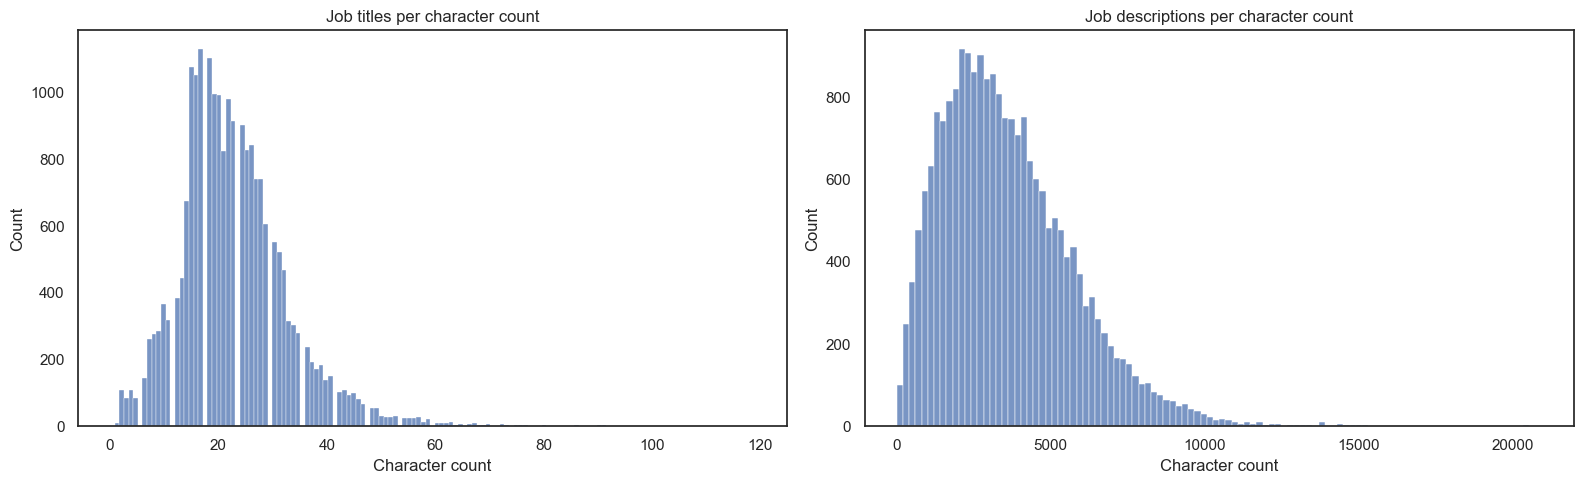

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Title - aka 'labels'
sns.histplot(data=job_posting, x="title_len", ax=axes[0])
axes[0].set_title("Job titles per character count")
axes[0].set_xlabel("Character count")

# Description - aka 'features'
sns.histplot(data=job_posting, x="description_len", ax=axes[1])
axes[1].set_title("Job descriptions per character count")
axes[1].set_xlabel("Character count")

fig.tight_layout()
plt.show()

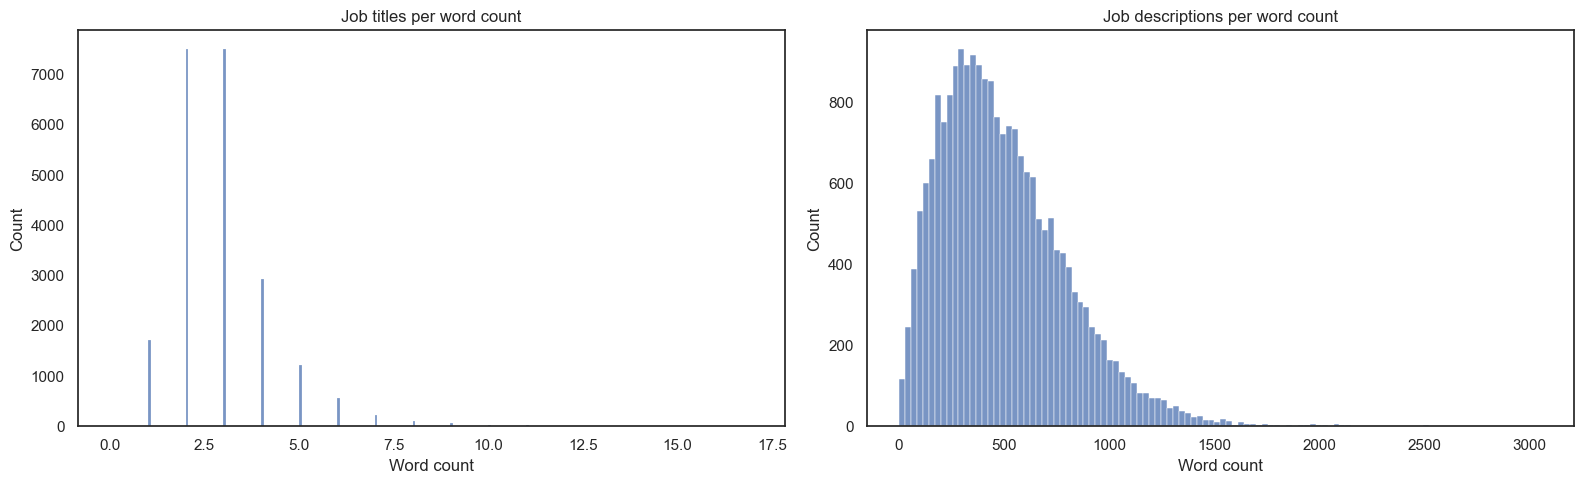

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Title - aka 'labels'
sns.histplot(data=job_posting, x="title_n_words", ax=axes[0])
axes[0].set_title("Job titles per word count")
axes[0].set_xlabel("Word count")

# Description - aka 'features'
sns.histplot(data=job_posting, x="description_n_words", ax=axes[1])
axes[1].set_title("Job descriptions per word count")
axes[1].set_xlabel("Word count")

fig.tight_layout()
plt.show()

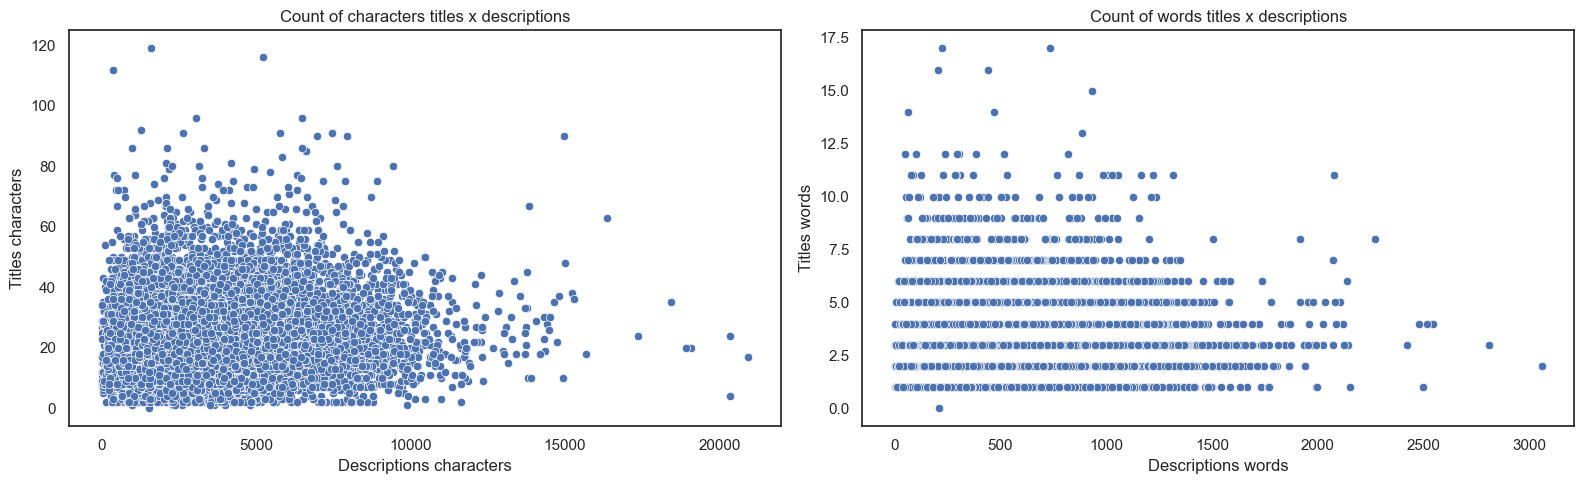

In [32]:
# Correlation between length of titles and discriptions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Character count
sns.scatterplot(data=job_posting, y="title_len", x="description_len", ax=axes[0])
axes[0].set_title("Count of characters titles x descriptions")
axes[0].set_xlabel("Descriptions characters")
axes[0].set_ylabel("Titles characters")

# Word count
sns.scatterplot(data=job_posting, y="title_n_words", x="description_n_words", ax=axes[1])
axes[1].set_title("Count of words titles x descriptions")
axes[1].set_xlabel("Descriptions words")
axes[1].set_ylabel("Titles words")

fig.tight_layout()
plt.show()

In [33]:
job_posting[["title_len", "description_len"]].corr()

,title_len,description_len
title_len,1.00000,0.06718
description_len,0.06718,1.00000


In [34]:
job_posting[["title_n_words", "description_n_words"]].corr()

,title_n_words,description_n_words
title_n_words,1.000000,0.063985
description_n_words,0.063985,1.000000


In [35]:
# BART Fine Tune

job_posting = job_posting.sample(n=2_000, random_state=123, ignore_index=True).copy(deep=True)

In [36]:
#BART Base + Tokenizer

# Tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# Model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

vocab.json: 100%|██████████| 899k/899k [00:00<00:00, 3.69MB/s]
c:\Users\Checkout\Documents\Fall 2023\uApply-Job-Recommendation-System\myenv\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Checkout\.cache\huggingface\hub\models--facebook--bart-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
mer

In [37]:
# 32-bit model approximate size
# 1 Byte => 8 bits
# 32-bit (torch.float) => 4 Bytes
model_size = model.num_parameters() * 4 / (1024**2) # MB
print(f"Model parameter count: {model.num_parameters():,}")
print(f"Model size (MB): {model_size:,.3f}")

Model parameter count: 139,420,416
Model size (MB): 531.847


In [38]:
def compute_size(model: torch.nn.Module) -> None:
    """
    Prints model's size in MiB.
    """
    # Get learnable params size
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
        
    # Get buffers size - Dropout, BatchNorm, etc...
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        
    model_size = param_size + buffer_size # Bytes
    model_size /= (1024**2) # B -> MiB
    print(f"Model size (MB): {model_size:,.3f}")

compute_size(model)

Model size (MB): 532.038


In [40]:
# Train/Val Split
# Split into train/validation
train_df, val_df = train_test_split(job_posting[["title", "description"]],
                                    test_size=.1,
                                    random_state=123)
print(f"Train DataFrame size: {train_df.shape}")
print(f"Val DataFrame size: {val_df.shape}")

Train DataFrame size: (1800, 2)
Val DataFrame size: (200, 2)


In [41]:
sample = train_df.sample(1, random_state=123).squeeze()
sample_description = sample["description"]
sample_title = sample["title"]

tokens = tokenizer(sample_description, return_tensors="pt").to(device)
# Set a small length since the titles are small
output = model.generate(**tokens, max_length=10) 
output_text = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
print(f"Original title: '{sample_title}'", "\n")
print(f"Generated: '{output_text}'")

Original title: 'Tax Processing Specialist III' 

Generated: 'Job Description:Employee Summary:'


In [42]:
train_set = Dataset.from_pandas(train_df,
                                preserve_index=False)

val_set = Dataset.from_pandas(val_df,
                              preserve_index=False)

In [43]:
train_set

Dataset({
    features: ['title', 'description'],
    num_rows: 1800
})

In [44]:
def tokenize_func(sample):
    global tokenizer
    tokenized_sample = tokenizer(sample["description"],
                               truncation=True)
    tokenized_label = tokenizer(sample["title"],
                              truncation=True)
    tokenized_sample.update({"labels": tokenized_label["input_ids"]})
    return tokenized_sample

train_set_tokenized = train_set.map(tokenize_func, batched=True, remove_columns=["title", "description"])
val_set_tokenized = val_set.map(tokenize_func, batched=True, remove_columns=["title", "description"])

Map: 100%|██████████| 200/200 [00:01<00:00, 141.35 examples/s]


In [45]:
# Rouge metric

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    global tokenizer, rouge
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [46]:
data_collator = DataCollatorForSeq2Seq(tokenizer, 
                                       padding=True,
                                       max_length=256,
                                       pad_to_multiple_of=8)

In [47]:
# Estimating train steps per epoch and total train steps
batch_size = 4
epochs = 10
grad_acc = 40
training_steps_per_epoch = int(np.ceil(len(train_set) / (batch_size * grad_acc))) - 1
training_steps = epochs * training_steps_per_epoch
print(f"Train steps: {training_steps}")
print(f"Steps per epoch: {training_steps_per_epoch}")
print(f"Train virtual batch_size: {batch_size * grad_acc}")

Train steps: 110
Steps per epoch: 11
Train virtual batch_size: 160


In [ ]:
train_args = Seq2SeqTrainingArguments(
    output_dir="bart-jobs-summarizer",
    seed=123,
    learning_rate=1e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=1e-2,
    num_train_epochs=10,
    fp16=True,
    gradient_accumulation_steps=40,
    gradient_checkpointing=True,
    warmup_steps=4,

    # Saving
    save_strategy="steps", # To use callbacks
    save_steps=2, # save_steps/eval_acc_steps - Save every 10/5 = 2 evaluations
    push_to_hub=False,

    # Callbacks
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",

    # Eval
    do_eval=True,
    predict_with_generate=True,
    greater_is_better=True,
    evaluation_strategy="steps",
    logging_strategy="steps",
    logging_steps=1,
    eval_accumulation_steps=5, # Reduces memory consumption during eval
    
    report_to="none", # Turn off WandB
)